## Линейные модели. Работа с признаками
### Выполнил: Земнухов Вадим

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


В этом рамках данного мини-проекта мы рассмотрим различные аспекты построения линейной модели. Будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [2]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

## Построение модели

In [3]:
data.shape

(53940, 11)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


Пропущенные значения отсутствуют.

Попытаемся понять, есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации).

In [5]:
data['Unnamed: 0']

0            1
1            2
2            3
3            4
4            5
         ...  
53935    53936
53936    53937
53937    53938
53938    53939
53939    53940
Name: Unnamed: 0, Length: 53940, dtype: int64

Как можно заметить, колонка 'Unnamed: 0' не несет в себе полезной информации. Это лишь порядковый номер брилианта в таблице Excel. Его можно удалить.

Также вызывают некоторые сомнения координаты x, y, z. По этим параметрам можно посчитать объем бриллианта, и зная его плотность посчитать массу и перевести в караты. Т.е. между массой и координатами есть линейная зависимость, что может помешать нашей модели. Однако, при этом известно, что на цену бриллианта влияет соотношение длины к ширине самого камня. С этой позиции пренебрегать координатами не стоит. Однако, нам неизвестно как располагался камень относительно системы координат при его измерении. Т.е. мы можем лишь предполагать, какая из координат (x, y или z) является длиной, а какая шириной. К тому же при этом важно знать форму камня, а этой информации в нашем датасете нет. Более того depth и table итак являются определяющими параметрами для огранки, а как известно огранка на цену бриллианта влияет. Исходя из этого, я считаю, что значениями x, y, z также можно пренебречь.

Удалим из нашего DataFrame ненужные столбцы.

In [6]:
data = data.drop(['Unnamed: 0', 'x', 'y', 'z'], axis=1)
data.head(10)

,carat,cut,color,clarity,depth,table,price
0,0.23,Ideal,E,SI2,61.5,55.0,326
1,0.21,Premium,E,SI1,59.8,61.0,326
2,0.23,Good,E,VS1,56.9,65.0,327
3,0.29,Premium,I,VS2,62.4,58.0,334
4,0.31,Good,J,SI2,63.3,58.0,335
5,0.24,Very Good,J,VVS2,62.8,57.0,336
6,0.24,Very Good,I,VVS1,62.3,57.0,336
7,0.26,Very Good,H,SI1,61.9,55.0,337
8,0.22,Fair,E,VS2,65.1,61.0,337
9,0.23,Very Good,H,VS1,59.4,61.0,338


Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется.

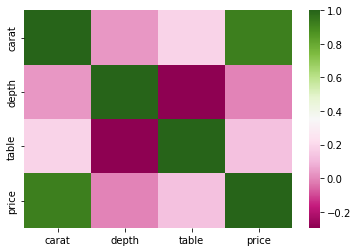

In [7]:
import seaborn as sns

corr = data.drop(['cut', 'color', 'clarity'], axis = 1).corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="PiYG");

Учитывая цветовой масштаб, можно сделать вывод, что на цену в большей степени влияет масса бриллианта в каратах, чуть более меньшей степени параментр table (пропускная способность поверхности к свету) и самой меньшей степени depth (глубина).

In [8]:
corr

,carat,depth,table,price
carat,1.000000,0.028224,0.181618,0.921591
depth,0.028224,1.000000,-0.295779,-0.010647
table,0.181618,-0.295779,1.000000,0.127134
price,0.921591,-0.010647,0.127134,1.000000


По числовым значениям корреляции можно сделать аналогичный вывод, однако сомнения вызывает параметр depth в связи с его довольно низким по модулю значением коэффициентом корреляции с целевой переменной.

Закодируем категориальные переменные при помощи OneHot-кодирования.

In [9]:
data = pd.get_dummies(data, columns=['cut', 'color', 'clarity'], drop_first= True )
data.head(10)

,carat,depth,table,price,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
5,0.24,62.8,57.0,336,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
6,0.24,62.3,57.0,336,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
7,0.26,61.9,55.0,337,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
8,0.22,65.1,61.0,337,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
9,0.23,59.4,61.0,338,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0


Создадим матрицу X, содержащую все признаки, и не содержащую целевую переменную price, а также вектор y, содержащий целевую переменную price.

In [10]:
X = data.drop('price', axis = 1)
X.head(10)

,carat,depth,table,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
5,0.24,62.8,57.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
6,0.24,62.3,57.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
7,0.26,61.9,55.0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
8,0.22,65.1,61.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
9,0.23,59.4,61.0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0


In [11]:
y = data['price']
y.head(10)

0    326
1    326
2    327
3    334
4    335
5    336
6    336
7    337
8    337
9    338
Name: price, dtype: int64

Разделим выборку на тренировочную и тестовую.

In [12]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=20) 

Отмасштабируем признаки, чтобы не подавать линейную регрессию большие числовые значения.

In [13]:
from sklearn.preprocessing import StandardScaler

object = StandardScaler() 
data_1 = object.fit_transform(Xtrain.iloc[:, [0, 1, 2]])
Xtrain.iloc[:, [0, 1, 2]] = data_1

data_1 = object.fit_transform(Xtest.iloc[:, [0, 1, 2]])
Xtest.iloc[:, [0, 1, 2]] = data_1

In [14]:
Xtrain

,carat,depth,table,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
4106,-0.035034,-0.101784,-0.649549,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
11613,0.725031,-1.789532,1.590477,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
19441,0.556127,-0.031461,-1.097555,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
24086,2.561855,1.023382,0.694466,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
36421,-0.858438,-1.367595,1.590477,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23452,1.485096,-0.734689,2.038482,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
23775,1.506209,0.109185,-0.201544,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
37135,-0.795100,-0.594044,-0.649549,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
27098,2.646307,-1.437918,0.694466,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [15]:
Xtest

,carat,depth,table,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
20244,1.514030,0.233158,3.806381,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
45013,-0.549829,0.164522,0.234725,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
53351,-0.212873,0.164522,1.127639,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
47212,-0.444530,0.301793,0.234725,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1460,0.124084,0.027251,0.234725,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35801,-1.034204,0.095887,-1.551103,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
14736,0.439981,-0.041384,-0.658189,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
20694,1.535090,0.095887,-1.551103,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
40607,-1.202683,-0.178655,-1.104646,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


Обучим линейную регрессию на тренировочной выборке и проверим её на тестовой.

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(Xtrain, ytrain)

pred_train = lr.predict(Xtrain)
pred_test = lr.predict(Xtest)

print(f'R^2_train = {round(r2_score(ytrain, pred_train), 5)}')
print(f'R^2_test = {round(r2_score(ytest, pred_test), 5)}')

R^2_train = 0.91593
R^2_test = 0.91616


R^2 незначительно отличается на тренировочной и тестовой выборках, при этом значения данной метрики довольно близки к 1, что говорит о неплохом качестве построенной модели.

In [17]:
from sklearn.metrics import mean_squared_error

print("Test RMSE = %.4f" % mean_squared_error(ytest, pred_test, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(ytrain, pred_train, squared=False))

Test RMSE = 1156.7075
Train RMSE = 1156.0172


In [18]:
ytrain

4106      3537
11613     5047
19441     8093
24086    12229
36421      942
         ...  
23452    11442
23775    11834
37135      971
27098    17237
48483     1980
Name: price, Length: 37758, dtype: int64

Значения целевой переменной довольно сильно разнятся между собой. Присутствуют, как значения порядка 17 237, так и 971. Возможно, это и привело к довольно высокому значению RMSE. Тем не менее мы видим, что эти значения для тренировочной и тестовой выборки получились приблизительно одинаковыми.

Проверим веса, которые линейная регрессия присвоила признакам.

In [19]:
print(f'w_0 = {lr.intercept_}')
w = lr.coef_
for i in range(len(w)):
    print(f'w_{i+1} = {w[i]}')

w_0 = -314.87069832707857
w_1 = 4213.592190631784
w_2 = -30.362995322263476
w_3 = -65.62524796056078
w_4 = 677.7316577689937
w_5 = 916.7545499197532
w_6 = 850.0544121883315
w_7 = 823.863395900659
w_8 = -207.75791918626572
w_9 = -286.26840460030803
w_10 = -501.11549438184767
w_11 = -980.4244651047087
w_12 = -1404.685283418315
w_13 = -2272.976216011414
w_14 = 5479.207261431959
w_15 = 3631.179809140047
w_16 = 2697.5359691559966
w_17 = 4597.16350835996
w_18 = 4288.713490064226
w_19 = 5120.327048583875
w_20 = 5032.045061839706


Среди вещественных признаков наибольший вес имеет масса бриллианта в каратах. При этом вес этого признака по модулю на 2 порядка выше, чем для depth и table.

## Попытка улучшить качество модели

В нашем случае нельзя с полной уверенностью утверждать о линейной зависимости признаков между собой. Теоретически могла наблюдаться линейная зависимость между параметрами x, y, z и массой в каратах, но для того, чтобы это предотвратить мы изначально не учитывали признаки x, y, z. 

По корреляционной матрице можно наблюдать, что теоретически может быть небольшая зависимость между массой в каратах и признаками depth и table. К тому же вес признака carat на 2 порядка выше весов depth и table по модулю. В качестве эксперимената попробуем удалить признаки depth и table по очереди, а затем удалить оба признака, и посмотрим в каком случае качество модели будет лучше.

In [20]:
Xtrain_1 = Xtrain.drop('depth', axis = 1)
Xtest_1 = Xtest.drop('depth', axis = 1)

lr.fit(Xtrain_1, ytrain)

pred_train_1 = lr.predict(Xtrain_1)
pred_test_1 = lr.predict(Xtest_1)

print(f'R^2_train = {round(r2_score(ytrain, pred_train_1), 5)}')
print(f'R^2_test = {round(r2_score(ytest, pred_test_1), 5)}')

print("Test RMSE = %.4f" % mean_squared_error(ytest, pred_test_1, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(ytrain, pred_train_1, squared=False))

R^2_train = 0.91589
R^2_test = 0.91612
Test RMSE = 1156.9844
Train RMSE = 1156.3061


Как можно заметить качество модели не сильно изменилось при удалении параметра depth

In [21]:
Xtrain_1 = Xtrain.drop('table', axis = 1)
Xtest_1 = Xtest.drop('table', axis = 1)

lr.fit(Xtrain_1, ytrain)

pred_train_1 = lr.predict(Xtrain_1)
pred_test_1 = lr.predict(Xtest_1)

print(f'R^2_train = {round(r2_score(ytrain, pred_train_1), 5)}')
print(f'R^2_test = {round(r2_score(ytest, pred_test_1), 5)}')

print("Test RMSE = %.4f" % mean_squared_error(ytest, pred_test_1, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(ytrain, pred_train_1, squared=False))

R^2_train = 0.91578
R^2_test = 0.91616
Test RMSE = 1156.7420
Train RMSE = 1157.0498


Качество модели также не улучшилось при удалении признака table. Поробуем удалить оба признака.

In [22]:
Xtrain_1 = Xtrain.drop(['depth','table'], axis = 1)
Xtest_1 = Xtest.drop(['depth','table'], axis = 1)

lr.fit(Xtrain_1, ytrain)

pred_train_1 = lr.predict(Xtrain_1)
pred_test_1 = lr.predict(Xtest_1)

print(f'R^2_train = {round(r2_score(ytrain, pred_train_1), 5)}')
print(f'R^2_test = {round(r2_score(ytest, pred_test_1), 5)}')

print("Test RMSE = %.4f" % mean_squared_error(ytest, pred_test_1, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(ytrain, pred_train_1, squared=False))

R^2_train = 0.91578
R^2_test = 0.91614
Test RMSE = 1156.8170
Train RMSE = 1157.0670


И снова получили крайне незначительные изменения. Следовательно изначальная модель (без удаления признаков depth и table) была построена удачно. При этом при использовании модели без удаления этих двух признаков значения RMSE для тренировочной и тестовой выборки, хоть и незначительно, но всё же были ближе друг к другу.

Для улучшения качества модели в идеальном случае нужны дополнительные признаки, получить которые в нашем случае нет возможности. Попробуем найти зависимость логарифма цены от логарифма вещественных характеристик.

In [23]:
data_2 = data

In [24]:
X_2 = data_2.drop('price', axis = 1)
X_2

,carat,depth,table,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
53936,0.72,63.1,55.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
53937,0.70,62.8,60.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
53938,0.86,61.0,58.0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [25]:
y_2 = data_2['price']
y_2

0         326
1         326
2         327
3         334
4         335
         ... 
53935    2757
53936    2757
53937    2757
53938    2757
53939    2757
Name: price, Length: 53940, dtype: int64

In [26]:
Xtrain_2, Xtest_2, ytrain_2, ytest_2 = train_test_split(X_2, y_2, test_size=0.3, random_state=20) 

In [27]:
Xtrain_2['carat'] = np.log(Xtrain_2['carat'])
Xtrain_2['depth'] = np.log(Xtrain_2['depth'])
Xtrain_2['table'] = np.log(Xtrain_2['table'])
Xtest_2['carat'] = np.log(Xtest_2['carat'])
Xtest_2['depth'] = np.log(Xtest_2['depth'])
Xtest_2['table'] = np.log(Xtest_2['table'])

ytrain_2 = np.log(ytrain_2)
ytest_2 = np.log(ytest_2)

In [28]:
object = StandardScaler() 
data_1 = object.fit_transform(Xtrain_2.iloc[:, [0, 1, 2]])
Xtrain_2.iloc[:, [0, 1, 2]] = data_1

data_1 = object.fit_transform(Xtest_2.iloc[:, [0, 1, 2]])
Xtest_2.iloc[:, [0, 1, 2]] = data_1

In [29]:
lr.fit(Xtrain_2, ytrain_2)

pred_train_2 = lr.predict(Xtrain_2)
pred_test_2 = lr.predict(Xtest_2)

print(f'R^2_train = {round(r2_score(ytrain_2, pred_train_2), 5)}')
print(f'R^2_test = {round(r2_score(ytest_2, pred_test_2), 5)}')

print("Test RMSE = %.4f" % mean_squared_error(ytest_2, pred_test_2, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(ytrain_2, pred_train_2, squared=False))

R^2_train = 0.9827
R^2_test = 0.98229
Test RMSE = 0.1348
Train RMSE = 0.1335


In [30]:
print(f'w_0 = {lr.intercept_}')
w = lr.coef_
for i in range(len(w)):
    print(f'w_{i+1} = {w[i]}')

w_0 = 7.100819529638816
w_1 = 1.1025244629856472
w_2 = -0.0014572258380819304
w_3 = -0.001217386654520685
w_4 = 0.0827333724636791
w_5 = 0.16327269531873273
w_6 = 0.14120414052060518
w_7 = 0.12066816536229358
w_8 = -0.05695818533082608
w_9 = -0.09513305272525971
w_10 = -0.1615489637809189
w_11 = -0.2526829331262069
w_12 = -0.3704915783619236
w_13 = -0.5117957410996019
w_14 = 1.1208014611035888
w_15 = 0.5998475190844695
w_16 = 0.4351069088260666
w_17 = 0.8192659649034236
w_18 = 0.750761816856751
w_19 = 1.0267321483698655
w_20 = 0.9556211636843466


По значениям метрик и весов можно сделать вывод, что при логарифмировании целевой переменной и признаков качество модели улучшилось.

## Выводы

Наилучшего качества модели удалось добиться при логарифмировании признаков и целевой переменной. Коэффициент R^2 при этом стал больше стремиться к единице, а также уменьшились значения весов, что упрощает работу модели.

В итоге мы получили хорошее качество модели.